Streamlit App Link - https://harshjamgaonkar05-es-335-ml-assignment-3-question-1app-vjtik6.streamlit.app/

# Next-Word Prediction using MLP - Complete Training

## Imports

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: Tesla P100-PCIE-16GB
GPU Memory: 17.06 GB


## Part 2: Define Model Architecture and Helper Functions

In [2]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.LongTensor(X)
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class NextWordMLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_length, hidden_dim, activation='relu', dropout=0.5):
        super(NextWordMLP, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        input_dim = context_length * embedding_dim
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, vocab_size)
        
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        else:
            raise ValueError(f"Unknown activation: {activation}")
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        embedded = self.embedding(x)
        embedded = embedded.view(embedded.size(0), -1)
        
        h1 = self.activation(self.fc1(embedded))
        h1 = self.dropout(h1)
        
        h2 = self.activation(self.fc2(h1))
        h2 = self.dropout(h2)
        
        output = self.fc3(h2)
        return output
    
    def get_embeddings(self):
        return self.embedding.weight.data.cpu().numpy()

print("Model architecture defined")

Model architecture defined


In [3]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    return total_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    return total_loss / len(loader), 100. * correct / total

def generate_text(model, seed_text, num_words, word_to_idx, idx_to_word, context_length, temperature=1.0, is_code=False):
    model.eval()
    
    if is_code:
        words = seed_text if isinstance(seed_text, list) else seed_text.split()
    else:
        words = seed_text.lower().split()
    
    generated = words.copy()
    
    for _ in range(num_words):
        context = generated[-context_length:] if len(generated) >= context_length else generated
        context_indices = [word_to_idx.get(w, word_to_idx['<UNK>']) for w in context]
        
        if len(context_indices) < context_length:
            context_indices = [word_to_idx['<START>']] * (context_length - len(context_indices)) + context_indices
        
        context_tensor = torch.LongTensor([context_indices]).to(device)
        
        with torch.no_grad():
            output = model(context_tensor) / temperature
            probs = F.softmax(output, dim=1)
            predicted_idx = torch.multinomial(probs, 1).item()
        
        next_word = idx_to_word[predicted_idx]
        if next_word == '<END>':
            break
        generated.append(next_word)
    
    return ' '.join(generated)

print("Training and generation functions defined")

Training and generation functions defined


---
# Part 3: Shakespeare Model (Category I - Natural Language)

## Task 1.1 & 1.2 - Shakespeare Dataset

In [ ]:
import os

OUTPUT_DIR = '/kaggle/working' if os.path.exists('/kaggle') else '.'
os.makedirs(OUTPUT_DIR, exist_ok=True)
MODELS_DIR = os.path.join(OUTPUT_DIR, 'Models')
os.makedirs(MODELS_DIR, exist_ok=True)

KAGGLE_SHAKESPEARE = '/kaggle/input/ml-word-gen-data/shakespeare_processed.pkl'
KAGGLE_LINUX = '/kaggle/input/ml-word-gen-data/linux_kernel_processed.pkl'

if os.path.exists(KAGGLE_SHAKESPEARE):
    SHAKESPEARE_DATA_PATH = KAGGLE_SHAKESPEARE
elif os.path.exists(LOCAL_SHAKESPEARE):
    SHAKESPEARE_DATA_PATH = LOCAL_SHAKESPEARE
else:
    raise FileNotFoundError('Shakespeare processed file not found. Upload to Kaggle dataset or place locally.')

if os.path.exists(KAGGLE_LINUX):
    LINUX_DATA_PATH = KAGGLE_LINUX
elif os.path.exists(LOCAL_LINUX):
    LINUX_DATA_PATH = LOCAL_LINUX
else:
    LINUX_DATA_PATH = None

BATCH_SIZE = 256
EMBEDDING_DIM = 64
HIDDEN_DIM = 1024
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
DROPOUT = 0.5
NUM_EPOCHS = 500
PATIENCE = 10

print("="*70)
print("LOADING SHAKESPEARE DATASET (Category I)")
print("="*70)

with open(SHAKESPEARE_DATA_PATH, 'rb') as f:
    shakespeare_data = pickle.load(f)

shak_X = shakespeare_data['X']
shak_y = shakespeare_data['y']
shak_vocab = shakespeare_data['vocab']
shak_word_to_idx = shakespeare_data['word_to_idx']
shak_idx_to_word = shakespeare_data['idx_to_word']
shak_context_length = shakespeare_data['context_length']
shak_vocab_stats = shakespeare_data['vocab_stats']

print("\nSHAKESPEARE DATASET STATISTICS (Task 1.1)")
print("="*70)
print(f"Vocabulary size: {shak_vocab_stats['vocab_size']:,}")
print(f"Total training samples: {len(shak_X):,}")
print(f"Context length: {shak_context_length}")
print(f"Total words in corpus: {shak_vocab_stats['total_words']:,}")
print(f"<UNK> percentage: {shak_vocab_stats.get('unk_percentage', 0):.2f}%")

print("\n10 Most frequent words:")
for word, count in shak_vocab_stats['most_common']:
    print(f"  {word}: {count:,}")

print("\n10 Least frequent words:")
for word, count in shak_vocab_stats['least_common']:
    print(f"  {word}: {count:,}")

LOADING SHAKESPEARE DATASET (Category I)

SHAKESPEARE DATASET STATISTICS (Task 1.1)
Vocabulary size: 15,237
Total training samples: 866,050
Context length: 5
Total words in corpus: 832,312
<UNK> percentage: 0.00%

10 Most frequent words:
  the: 26,198
  and: 23,483
  i: 19,999
  to: 18,072
  of: 16,348
  you: 13,518
  a: 13,436
  my: 12,011
  that: 10,444
  in: 10,272

10 Least frequent words:
  elbowroom: 1
  crumble: 1
  poisondill: 1
  faredead: 1
  parched: 1
  unreprievable: 1
  scalded: 1
  unwarily: 1
  sinewed: 1
  beforehand: 1


In [5]:
shak_X_train, shak_X_val, shak_y_train, shak_y_val = train_test_split(
    shak_X, shak_y, test_size=0.2, random_state=42
)

print("\nData Split:")
print(f"Training samples: {len(shak_X_train):,}")
print(f"Validation samples: {len(shak_X_val):,}")

shak_train_dataset = TextDataset(shak_X_train, shak_y_train)
shak_val_dataset = TextDataset(shak_X_val, shak_y_val)

shak_train_loader = DataLoader(shak_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
shak_val_loader = DataLoader(shak_val_dataset, batch_size=BATCH_SIZE)

print(f"\nBatch size: {BATCH_SIZE}")
print(f"Training batches: {len(shak_train_loader)}")
print(f"Validation batches: {len(shak_val_loader)}")


Data Split:
Training samples: 692,840
Validation samples: 173,210

Batch size: 256
Training batches: 2707
Validation batches: 677


In [6]:
ACTIVATION = 'relu'

shak_model = NextWordMLP(
    vocab_size=len(shak_vocab),
    embedding_dim=EMBEDDING_DIM,
    context_length=shak_context_length,
    hidden_dim=HIDDEN_DIM,
    activation=ACTIVATION,
    dropout=DROPOUT).to(device)

shak_criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
shak_optimizer = optim.Adam(shak_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
shak_scheduler = optim.lr_scheduler.ReduceLROnPlateau(shak_optimizer, mode='min', factor=0.5, patience=10, verbose=True)

print("\nSHAKESPEARE MODEL ARCHITECTURE (Task 1.2)")
print("="*70)
print(shak_model)
print(f"\nTotal parameters: {sum(p.numel() for p in shak_model.parameters()):,}")


SHAKESPEARE MODEL ARCHITECTURE (Task 1.2)
NextWordMLP(
  (embedding): Embedding(15237, 64)
  (fc1): Linear(in_features=320, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=15237, bias=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

Total parameters: 17,971,397


In [7]:
print("\nTRAINING SHAKESPEARE MODEL")
print("="*70)

shak_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
shak_best_val_loss = float('inf')
patience_counter = 0

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_epoch(shak_model, shak_train_loader, shak_criterion, shak_optimizer, device)
    val_loss, val_acc = validate(shak_model, shak_val_loader, shak_criterion, device)
    shak_scheduler.step(val_loss)
    
    shak_history['train_loss'].append(train_loss)
    shak_history['train_acc'].append(train_acc)
    shak_history['val_loss'].append(val_loss)
    shak_history['val_acc'].append(val_acc)
    
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    if val_loss < shak_best_val_loss:
        shak_best_val_loss = val_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': shak_model.state_dict(),
            'optimizer_state_dict': shak_optimizer.state_dict(),
            'val_loss': val_loss,
            'vocab': shak_vocab,
            'word_to_idx': shak_word_to_idx,
            'idx_to_word': shak_idx_to_word,
            'context_length': shak_context_length,
            'embedding_dim': EMBEDDING_DIM,
            'hidden_dim': HIDDEN_DIM,
            'activation': ACTIVATION
        }, os.path.join(MODELS_DIR, 'shakespeare_best_model.pth'))
        print(f"  Saved best model")
    else:
        patience_counter += 1
    
    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break
    
    if (epoch + 1) % 50 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': shak_model.state_dict(),
            'optimizer_state_dict': shak_optimizer.state_dict(),
            'history': shak_history
        }, os.path.join(MODELS_DIR, f'shakespeare_checkpoint_epoch_{epoch+1}.pth'))
        print(f"  Checkpoint saved")

print("\nShakespeare training completed!")
print(f"Best Validation Loss: {shak_best_val_loss:.4f}")
print(f"Final Validation Accuracy: {shak_history['val_acc'][-1]:.2f}%")


TRAINING SHAKESPEARE MODEL
Epoch [1/500]
  Train Loss: 6.9160, Train Acc: 6.98%
  Val Loss: 6.5624, Val Acc: 9.32%
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
Epoch [10/500]
  Train Loss: 6.2051, Train Acc: 11.73%
  Val Loss: 6.1858, Val Acc: 11.93%
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
Epoch [20/500]
  Train Loss: 6.0281, Train Acc: 13.36%
  Val Loss: 6.1417, Val Acc: 12.38%
  Saved best model
  Saved best model
Epoch [30/500]
  Train Loss: 5.9220, Train Acc: 14.47%
  Val Loss: 6.1390, Val Acc: 12.42%

Early stopping at epoch 34

Shakespeare training completed!
Best Validation Loss: 6.1348
Final Validation Accuracy: 12.43%


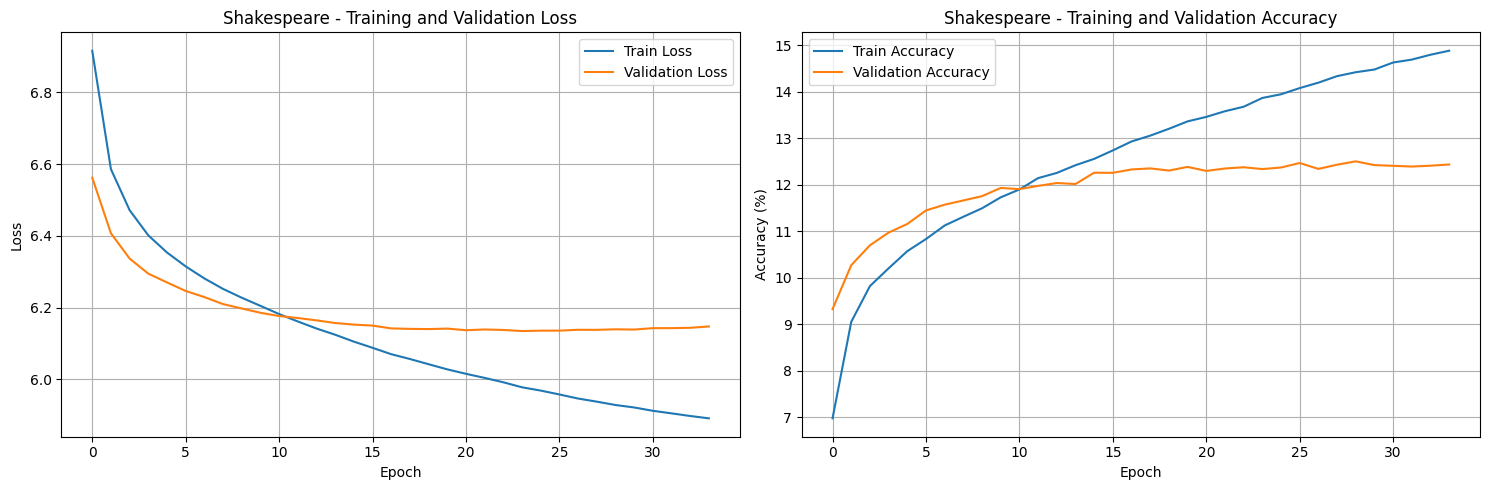

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(shak_history['train_loss'], label='Train Loss')
ax1.plot(shak_history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Shakespeare - Training and Validation Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(shak_history['train_acc'], label='Train Accuracy')
ax2.plot(shak_history['val_acc'], label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Shakespeare - Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'shakespeare_training_curves.png'), dpi=300, bbox_inches='tight')
plt.show()

In [9]:
checkpoint = torch.load(os.path.join(MODELS_DIR, 'shakespeare_best_model.pth'))
shak_model.load_state_dict(checkpoint['model_state_dict'])
shak_model.eval()

print("\nSHAKESPEARE TEXT GENERATION")
print("="*70)

test_seeds = ["to be or not to", "what is the", "i am", "the king of"]

for seed in test_seeds:
    print(f"\nSeed: '{seed}'")
    for temp in [0.5, 1.0, 1.5]:
        generated = generate_text(shak_model, seed, 20, shak_word_to_idx, shak_idx_to_word, 
                                 shak_context_length, temp, is_code=False)
        print(f"  T={temp}: {generated}")


SHAKESPEARE TEXT GENERATION

Seed: 'to be or not to'
  T=0.5: to be or not to be a traitor
  T=1.0: to be or not to do a second whats venus within the faiths paltry aloft entirely unhallowd debtor
  T=1.5: to be or not to fearing husband speak impediment business anon what condemned it goldsmith wilful biondello ill have fearfully matchd scythe gown is fame

Seed: 'what is the'
  T=0.5: what is the matter bardolph o my lord of york my heart <UNK> me
  T=1.0: what is the king where you are light lawless heedless owns their streets twixt petruchios sides have i wrongd my liberty to keep
  T=1.5: what is the clitus coinage to oerlook vast juggling pieces afire cataian themselves the sorrowful palm enough ends lasted pride subdued laughter varnishd

Seed: 'i am'
  T=0.5: i am the best to hear him
  T=1.0: i am bombast fairest i thank thee and opposed didst not kiss him well lethargy give it st
  T=1.5: i am dead have ears pomfret yielding seeing a county fluellen unlawfully guess visor ju

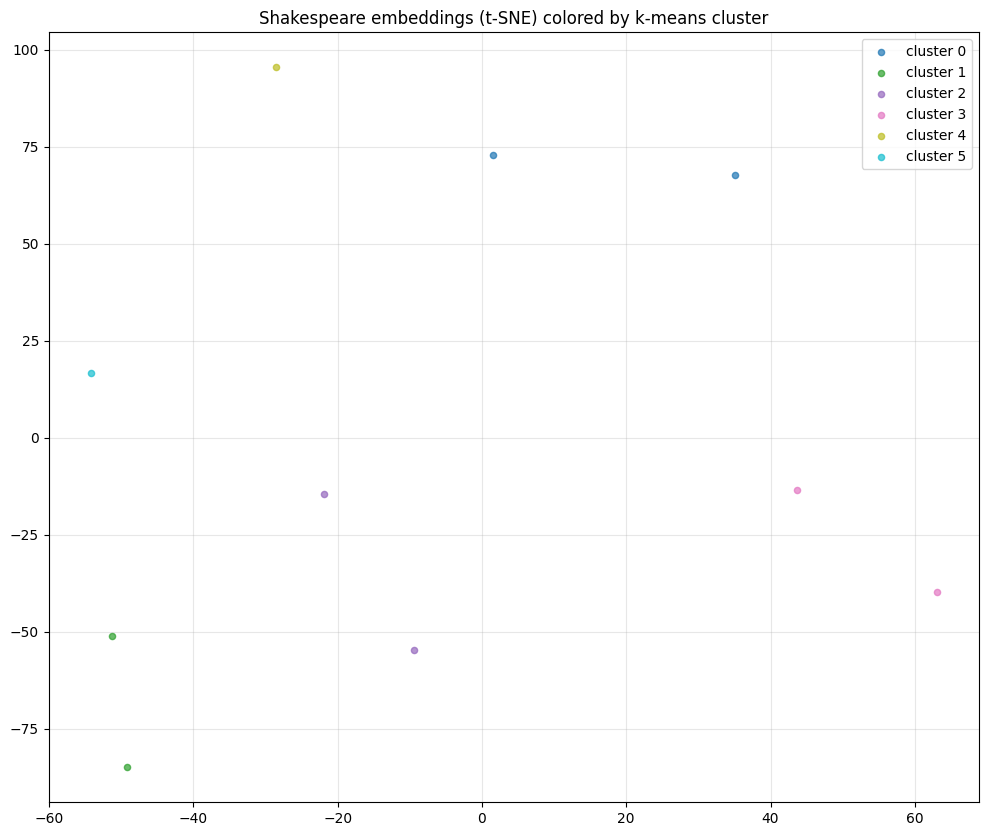

Saved 2D embeddings to shakespeare_embeddings_2d.csv and .npy
Silhouette Score (2D clusters): 0.2561

Nearest neighbors (cosine) for selected words:

king:
  king (dist=0.0000)
  friar (dist=0.4946)
  prince (dist=0.5206)
  euriphile (dist=0.5310)
  princess (dist=0.5543)
  simonides (dist=0.5652)
  fere (dist=0.5666)
  sap (dist=0.5723)
  albany (dist=0.5858)
  virtuous (dist=0.5960)

queen:
  queen (dist=0.0000)
  tyre (dist=0.5345)
  cardinal (dist=0.5578)
  andronicus (dist=0.5694)
  alban (dist=0.5909)
  won (dist=0.6011)
  assembly (dist=0.6019)
  claudius (dist=0.6047)
  domitius (dist=0.6083)
  merchant (dist=0.6103)

love:
  love (dist=0.0000)
  blame (dist=0.4718)
  loves (dist=0.5037)
  rebuke (dist=0.5381)
  hate (dist=0.5469)
  fulvia (dist=0.5501)
  sovereignty (dist=0.5596)
  plague (dist=0.5664)
  agincourt (dist=0.5705)
  honour (dist=0.5796)

death:
  death (dist=0.0000)
  blood (dist=0.4922)
  pride (dist=0.5130)
  rite (dist=0.5217)
  flesh (dist=0.5457)
  posture (

In [10]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import pandas as pd

N = 200
viz_words = [w for w, _ in shak_vocab_stats['most_common'][:N]]
viz_indices = [shak_word_to_idx[w] for w in viz_words]
shak_embeddings = shak_model.get_embeddings()
viz_embeddings = shak_embeddings[viz_indices]

viz_embeddings = np.asarray(viz_embeddings)
if viz_embeddings.ndim == 1:
    viz_embeddings = viz_embeddings.reshape(1, -1)

n_samples, n_features = viz_embeddings.shape[0], viz_embeddings.shape[1]
pca_dims = min(50, max(2, min(n_samples, n_features)))
pca = PCA(n_components=pca_dims, random_state=42)
emb_pca = pca.fit_transform(viz_embeddings)

perplexity = min(30, max(5, (n_samples - 1) // 3)) if n_samples > 3 else 2
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, n_iter=1000)
emb_2d = tsne.fit_transform(emb_pca)

k = 6
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(emb_2d)

sil_score = None
if len(set(clusters)) > 1 and len(viz_words) > k:
    try:
        sil_score = silhouette_score(emb_2d, clusters)
    except Exception:
        sil_score = None

nn_model = NearestNeighbors(n_neighbors=10, metric='cosine').fit(viz_embeddings)
query_words = ['king', 'queen', 'love', 'death', 'man', 'woman']
neighbors = {}
for q in query_words:
    if q in viz_words:
        qi = viz_words.index(q)
        distances, indices = nn_model.kneighbors([viz_embeddings[qi]])
        neighbors[q] = [(viz_words[idx], float(dist)) for idx, dist in zip(indices[0], distances[0])]
    elif q in shak_word_to_idx:
        full_emb = shak_model.get_embeddings()
        nn_full = NearestNeighbors(n_neighbors=10, metric='cosine').fit(full_emb)
        distances, indices = nn_full.kneighbors([full_emb[shak_word_to_idx[q]]])
        neighbors[q] = [(shak_idx_to_word[idx], float(dist)) for idx, dist in zip(indices[0], distances[0])]
    else:
        neighbors[q] = []

df2d = pd.DataFrame({
    'word': viz_words,
    'x': emb_2d[:, 0],
    'y': emb_2d[:, 1],
    'cluster': clusters
})
df2d.to_csv(os.path.join(OUTPUT_DIR, 'shakespeare_embeddings_2d.csv'), index=False)
np.save(os.path.join(OUTPUT_DIR, 'shakespeare_embeddings_2d.npy'), emb_2d)

plt.figure(figsize=(12, 10))
palette = plt.cm.get_cmap('tab10', k)
for ci in range(k):
    idxs = np.where(clusters == ci)[0]
    plt.scatter(emb_2d[idxs, 0], emb_2d[idxs, 1], label=f'cluster {ci}', s=20, alpha=0.7, color=palette(ci))

label_words = set(query_words + ['king', 'queen', 'love', 'death', 'man', 'woman'])
for i, w in enumerate(viz_words):
    if w in label_words:
        plt.annotate(w, (emb_2d[i, 0], emb_2d[i, 1]), fontsize=9)

plt.title('Shakespeare embeddings (t-SNE) colored by k-means cluster')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(OUTPUT_DIR, 'shakespeare_embeddings_tsne_clusters.png'), dpi=300, bbox_inches='tight')
plt.show()

print('Saved 2D embeddings to shakespeare_embeddings_2d.csv and .npy')
if sil_score is not None:
    print(f'Silhouette Score (2D clusters): {sil_score:.4f}')

print('\nNearest neighbors (cosine) for selected words:')
for q, neigh in neighbors.items():
    print(f"\n{q}:")
    for w, d in neigh[:10]:
        print(f"  {w} (dist={d:.4f})")


In [11]:
with open(os.path.join(OUTPUT_DIR, 'shakespeare_training_history.pkl'), 'wb') as f:
    pickle.dump(shak_history, f)

print("\nSHAKESPEARE MODEL COMPLETE!")
print("="*70)
print("Saved files:")
print("  - shakespeare_best_model.pth")
print("  - shakespeare_training_curves.png")
print("  - shakespeare_embeddings_tsne_clusters.png")
print("  - shakespeare_embeddings_2d.csv")
print("  - shakespeare_embeddings_2d.npy")
print("  - shakespeare_training_history.pkl")


SHAKESPEARE MODEL COMPLETE!
Saved files:
  - shakespeare_best_model.pth
  - shakespeare_training_curves.png
  - shakespeare_embeddings_tsne_clusters.png
  - shakespeare_embeddings_2d.csv
  - shakespeare_embeddings_2d.npy
  - shakespeare_training_history.pkl


---
# Part 4: Linux Kernel Model (Category II - Structured Text)

## Task 1.1 & 1.2 - Linux Kernel Code Dataset

In [12]:
print("="*70)
print("LOADING LINUX KERNEL DATASET (Category II)")
print("="*70)

with open(LINUX_DATA_PATH, 'rb') as f:
    linux_data = pickle.load(f)

linux_X = linux_data['X']
linux_y = linux_data['y']
linux_vocab = linux_data['vocab']
linux_word_to_idx = linux_data['word_to_idx']
linux_idx_to_word = linux_data['idx_to_word']
linux_context_length = linux_data['context_length']
linux_vocab_stats = linux_data['vocab_stats']

print("\nLINUX KERNEL DATASET STATISTICS (Task 1.1)")
print("="*70)
print(f"Vocabulary size: {linux_vocab_stats['vocab_size']:,}")
print(f"Total training samples: {len(linux_X):,}")
print(f"Context length: {linux_context_length}")
print(f"Total tokens in corpus: {linux_vocab_stats['total_tokens']:,}")
print(f"<UNK> percentage: {linux_vocab_stats.get('unk_percentage', 0):.2f}%")

print("\n10 Most frequent tokens:")
for token, count in linux_vocab_stats['most_common']:
    print(f"  {repr(token)}: {count:,}")

print("\n10 Least frequent tokens:")
for token, count in linux_vocab_stats['least_common']:
    print(f"  {repr(token)}: {count:,}")

LOADING LINUX KERNEL DATASET (Category II)

LINUX KERNEL DATASET STATISTICS (Task 1.1)
Vocabulary size: 38,255
Total training samples: 833,043
Context length: 10
Total tokens in corpus: 759,638
<UNK> percentage: 8.14%

10 Most frequent tokens:
  '*': 33,504
  '=': 28,003
  '{': 18,915
  'if': 17,702
  '}': 16,965
  'the': 16,080
  '*/': 13,445
  '/*': 12,190
  'struct': 10,997
  'return': 10,130

10 Least frequent tokens:
  'NOKPROBE_SYMBOL(context_tracking_user_exit);': 1
  '__context_tracking_task_switch': 1
  'user-kernel': 1
  'syscalls.': 1
  'TIF': 1
  '__context_tracking_task_switch(struct': 1
  'clear_tsk_thread_flag(prev,': 1
  'set_tsk_thread_flag(next,': 1
  'CONFIG_CONTEXT_TRACKING_FORCE': 1
  'context_tracking_init(void)': 1


In [13]:
linux_X_train, linux_X_val, linux_y_train, linux_y_val = train_test_split(
    linux_X, linux_y, test_size=0.2, random_state=42
)

print("\nData Split:")
print(f"Training samples: {len(linux_X_train):,}")
print(f"Validation samples: {len(linux_X_val):,}")

linux_train_dataset = TextDataset(linux_X_train, linux_y_train)
linux_val_dataset = TextDataset(linux_X_val, linux_y_val)

linux_train_loader = DataLoader(linux_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
linux_val_loader = DataLoader(linux_val_dataset, batch_size=BATCH_SIZE)

print(f"\nBatch size: {BATCH_SIZE}")
print(f"Training batches: {len(linux_train_loader)}")
print(f"Validation batches: {len(linux_val_loader)}")


Data Split:
Training samples: 666,434
Validation samples: 166,609

Batch size: 256
Training batches: 2604
Validation batches: 651


In [14]:
linux_model = NextWordMLP(
    vocab_size=len(linux_vocab),
    embedding_dim=EMBEDDING_DIM,
    context_length=linux_context_length,
    hidden_dim=HIDDEN_DIM,
    activation=ACTIVATION,
    dropout=DROPOUT).to(device)

linux_criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
linux_optimizer = optim.Adam(linux_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
linux_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    linux_optimizer, mode='min', factor=0.5, patience=10, verbose=True
)

print("\nLINUX KERNEL MODEL ARCHITECTURE (Task 1.2)")
print("="*70)
print(linux_model)
print(f"\nTotal parameters: {sum(p.numel() for p in linux_model.parameters()):,}")


LINUX KERNEL MODEL ARCHITECTURE (Task 1.2)
NextWordMLP(
  (embedding): Embedding(38255, 64)
  (fc1): Linear(in_features=640, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=38255, bias=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

Total parameters: 43,365,679


In [15]:
print("\nTRAINING LINUX KERNEL MODEL")
print("="*70)

linux_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
linux_best_val_loss = float('inf')
patience_counter = 0

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_epoch(linux_model, linux_train_loader, linux_criterion, linux_optimizer, device)
    val_loss, val_acc = validate(linux_model, linux_val_loader, linux_criterion, device)
    linux_scheduler.step(val_loss)
    
    linux_history['train_loss'].append(train_loss)
    linux_history['train_acc'].append(train_acc)
    linux_history['val_loss'].append(val_loss)
    linux_history['val_acc'].append(val_acc)
    
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    if val_loss < linux_best_val_loss:
        linux_best_val_loss = val_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': linux_model.state_dict(),
            'optimizer_state_dict': linux_optimizer.state_dict(),
            'val_loss': val_loss,
            'vocab': linux_vocab,
            'word_to_idx': linux_word_to_idx,
            'idx_to_word': linux_idx_to_word,
            'context_length': linux_context_length,
            'embedding_dim': EMBEDDING_DIM,
            'hidden_dim': HIDDEN_DIM,
            'activation': ACTIVATION
        }, os.path.join(MODELS_DIR, 'linux_kernel_best_model.pth'))
        print(f"  Saved best model")
    else:
        patience_counter += 1
    
    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break
    
    if (epoch + 1) % 50 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': linux_model.state_dict(),
            'optimizer_state_dict': linux_optimizer.state_dict(),
            'history': linux_history
        }, os.path.join(MODELS_DIR, f'linux_kernel_checkpoint_epoch_{epoch+1}.pth'))
        print(f"  Checkpoint saved")

print("\nLinux Kernel training completed!")
print(f"Best Validation Loss: {linux_best_val_loss:.4f}")
print(f"Final Validation Accuracy: {linux_history['val_acc'][-1]:.2f}%")


TRAINING LINUX KERNEL MODEL
Epoch [1/500]
  Train Loss: 6.0749, Train Acc: 28.46%
  Val Loss: 5.5626, Val Acc: 31.81%
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
Epoch [10/500]
  Train Loss: 4.9401, Train Acc: 37.33%
  Val Loss: 4.9229, Val Acc: 37.66%
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
Epoch [20/500]
  Train Loss: 4.6836, Train Acc: 40.15%
  Val Loss: 4.8357, Val Acc: 38.91%
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
Epoch [30/500]
  Train Loss: 4.5419, Train Acc: 41.80%
  Val Loss: 4.8344, Val Acc: 39.43%

Early stopping at epoch 38

Linux Kernel training completed!
Best Validation Loss: 4.8295
Fina

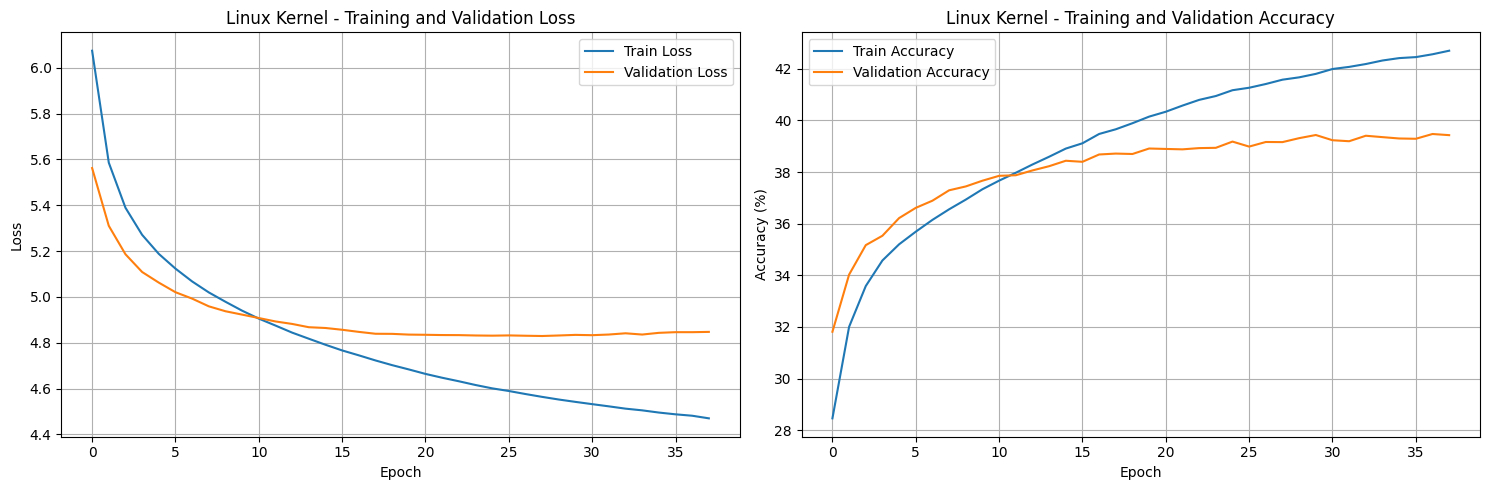

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(linux_history['train_loss'], label='Train Loss')
ax1.plot(linux_history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Linux Kernel - Training and Validation Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(linux_history['train_acc'], label='Train Accuracy')
ax2.plot(linux_history['val_acc'], label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Linux Kernel - Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'linux_kernel_training_curves.png'), dpi=300, bbox_inches='tight')
plt.show()

In [17]:
checkpoint = torch.load(os.path.join(MODELS_DIR, 'linux_kernel_best_model.pth'))
linux_model.load_state_dict(checkpoint['model_state_dict'])
linux_model.eval()

print("\nLINUX KERNEL CODE GENERATION")
print("="*70)

test_seeds = [
    ['struct', 'task_struct', '*'],
    ['if', '('],
    ['int', 'ret', '='],
    ['static', 'void']
]

for seed in test_seeds:
    print(f"\nSeed: {' '.join(seed)}")
    for temp in [0.5, 1.0, 1.5]:
        generated = generate_text(linux_model, seed, 20, linux_word_to_idx, linux_idx_to_word, 
                                 linux_context_length, temp, is_code=True)
        print(f"  T={temp}: {generated}")


LINUX KERNEL CODE GENERATION

Seed: struct task_struct *
  T=0.5: struct task_struct *
  T=1.0: struct task_struct *
  T=1.5: struct task_struct * interrupts. name. out_unlock_cgroup; dfl_root <UNK> print_trace_line(&iter); mutex_unlock(&klp_mutex); symtab report. tv_nsec=0 &rb->aux_wakeup); s->seq.len

Seed: if (
  T=0.5: if (
  T=1.0: if ( mask); ram < aggregated + 1)) {
  T=1.5: if ( crash_map_reserved_pages(); __iomem *pid_ns, str_item <UNK> desc_size __alloc_filter(); 45 rcu_expedited sd_lb_stats Imagine

Seed: int ret =
  T=0.5: int ret = <UNK>
  T=1.0: int ret = 0;
  T=1.5: int ret = pps_reset_freq_interval(); set_normalized_timespec64(&tmp, stack->index codes. cputime_one_jiffy; data[thr].unc_len whitespace extends persistent_clock_exists;

Seed: static void
  T=0.5: static void <UNK> rcu_head *head)
  T=1.0: static void <UNK> rq *rq) dl_se->dl_bw
  T=1.5: static void term subclass;


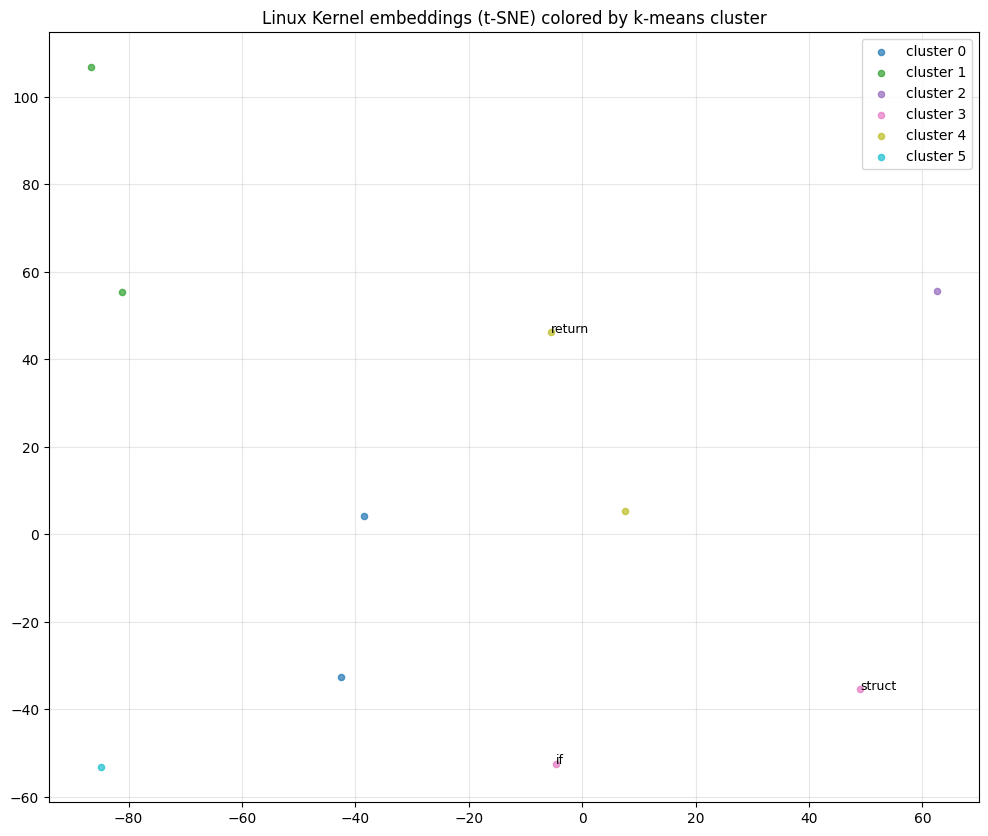

Saved 2D embeddings to linux_kernel_embeddings_2d.csv and .npy
Silhouette Score (2D clusters): 0.2244

Nearest neighbors (cosine) for selected tokens:

struct:
  struct (dist=0.0000)
  the (dist=0.8060)
  /* (dist=0.8396)
  { (dist=0.8990)
  = (dist=0.9526)
  return (dist=0.9969)
  if (dist=1.0094)
  * (dist=1.0115)
  */ (dist=1.0235)
  } (dist=1.0738)

int:
  int (dist=0.0000)
  size_t (dist=0.4314)
  pid_t (dist=0.4497)
  atomic_t (dist=0.4751)
  irqreturn_t (dist=0.4927)
  __u64 (dist=0.4928)
  uint64_t (dist=0.5036)
  item, (dist=0.5064)
  u16 (dist=0.5105)
  blk_io_trace_remap (dist=0.5153)

void:
  void (dist=0.0000)
  Elf_Sym (dist=0.3851)
  kprobe_opcode_t (dist=0.3945)
  traceprobe_parse_probe_arg(char (dist=0.4683)
  gcov_info (dist=0.4837)
  __percpu (dist=0.5198)
  (void (dist=0.5226)
  subprocess_info (dist=0.5230)
  lockdep_subclass_key (dist=0.5305)
  (cpumask_test_cpu(cpu, (dist=0.5315)

static:
  static (dist=0.0000)
  nokprobe_inline (dist=0.4157)
  noinline (dist=0.4

In [18]:
N = 200
linux_viz_words = [w for w, _ in linux_vocab_stats['most_common'][:N]]
linux_viz_indices = [linux_word_to_idx[w] for w in linux_viz_words]
linux_embeddings = linux_model.get_embeddings()
linux_viz_embeddings = linux_embeddings[linux_viz_indices]

linux_viz_embeddings = np.asarray(linux_viz_embeddings)
if linux_viz_embeddings.ndim == 1:
    linux_viz_embeddings = linux_viz_embeddings.reshape(1, -1)

n_samples, n_features = linux_viz_embeddings.shape[0], linux_viz_embeddings.shape[1]
pca_dims = min(50, max(2, min(n_samples, n_features)))
pca = PCA(n_components=pca_dims, random_state=42)
linux_emb_pca = pca.fit_transform(linux_viz_embeddings)

perplexity = min(30, max(5, (n_samples - 1) // 3)) if n_samples > 3 else 2
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, n_iter=1000)
linux_emb_2d = tsne.fit_transform(linux_emb_pca)

k = 6
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
linux_clusters = kmeans.fit_predict(linux_emb_2d)

linux_sil_score = None
if len(set(linux_clusters)) > 1 and len(linux_viz_words) > k:
    try:
        linux_sil_score = silhouette_score(linux_emb_2d, linux_clusters)
    except Exception:
        linux_sil_score = None

nn_model = NearestNeighbors(n_neighbors=10, metric='cosine').fit(linux_viz_embeddings)
query_tokens = ['struct', 'int', 'void', 'static', 'return', 'if']
linux_neighbors = {}
for q in query_tokens:
    if q in linux_viz_words:
        qi = linux_viz_words.index(q)
        distances, indices = nn_model.kneighbors([linux_viz_embeddings[qi]])
        linux_neighbors[q] = [(linux_viz_words[idx], float(dist)) for idx, dist in zip(indices[0], distances[0])]
    elif q in linux_word_to_idx:
        full_emb = linux_model.get_embeddings()
        nn_full = NearestNeighbors(n_neighbors=10, metric='cosine').fit(full_emb)
        distances, indices = nn_full.kneighbors([full_emb[linux_word_to_idx[q]]])
        linux_neighbors[q] = [(linux_idx_to_word[idx], float(dist)) for idx, dist in zip(indices[0], distances[0])]
    else:
        linux_neighbors[q] = []

df_linux = pd.DataFrame({
    'token': linux_viz_words,
    'x': linux_emb_2d[:, 0],
    'y': linux_emb_2d[:, 1],
    'cluster': linux_clusters
})
df_linux.to_csv(os.path.join(OUTPUT_DIR, 'linux_kernel_embeddings_2d.csv'), index=False)
np.save(os.path.join(OUTPUT_DIR, 'linux_kernel_embeddings_2d.npy'), linux_emb_2d)

plt.figure(figsize=(12, 10))
palette = plt.cm.get_cmap('tab10', k)
for ci in range(k):
    idxs = np.where(linux_clusters == ci)[0]
    plt.scatter(linux_emb_2d[idxs, 0], linux_emb_2d[idxs, 1], label=f'cluster {ci}', s=20, alpha=0.7, color=palette(ci))

label_tokens = set(query_tokens + ['struct', 'int', 'void', 'static', 'return', 'if'])
for i, w in enumerate(linux_viz_words):
    if w in label_tokens:
        plt.annotate(w, (linux_emb_2d[i, 0], linux_emb_2d[i, 1]), fontsize=9)

plt.title('Linux Kernel embeddings (t-SNE) colored by k-means cluster')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(OUTPUT_DIR, 'linux_kernel_embeddings_tsne_clusters.png'), dpi=300, bbox_inches='tight')
plt.show()

print('Saved 2D embeddings to linux_kernel_embeddings_2d.csv and .npy')
if linux_sil_score is not None:
    print(f'Silhouette Score (2D clusters): {linux_sil_score:.4f}')

print('\nNearest neighbors (cosine) for selected tokens:')
for q, neigh in linux_neighbors.items():
    print(f"\n{q}:")
    for w, d in neigh[:10]:
        print(f"  {w} (dist={d:.4f})")


In [19]:
with open(os.path.join(OUTPUT_DIR, 'linux_kernel_training_history.pkl'), 'wb') as f:
    pickle.dump(linux_history, f)

print("\nLINUX KERNEL MODEL COMPLETE!")
print("="*70)
print("Saved files:")
print("  - linux_kernel_best_model.pth")
print("  - linux_kernel_training_curves.png")
print("  - linux_kernel_embeddings_tsne_clusters.png")
print("  - linux_kernel_embeddings_2d.csv")
print("  - linux_kernel_embeddings_2d.npy")
print("  - linux_kernel_training_history.pkl")


LINUX KERNEL MODEL COMPLETE!
Saved files:
  - linux_kernel_best_model.pth
  - linux_kernel_training_curves.png
  - linux_kernel_embeddings_tsne_clusters.png
  - linux_kernel_embeddings_2d.csv
  - linux_kernel_embeddings_2d.npy
  - linux_kernel_training_history.pkl


---
# Part 5: Comparative Analysis (Task 1.5)

## Compare Both Models

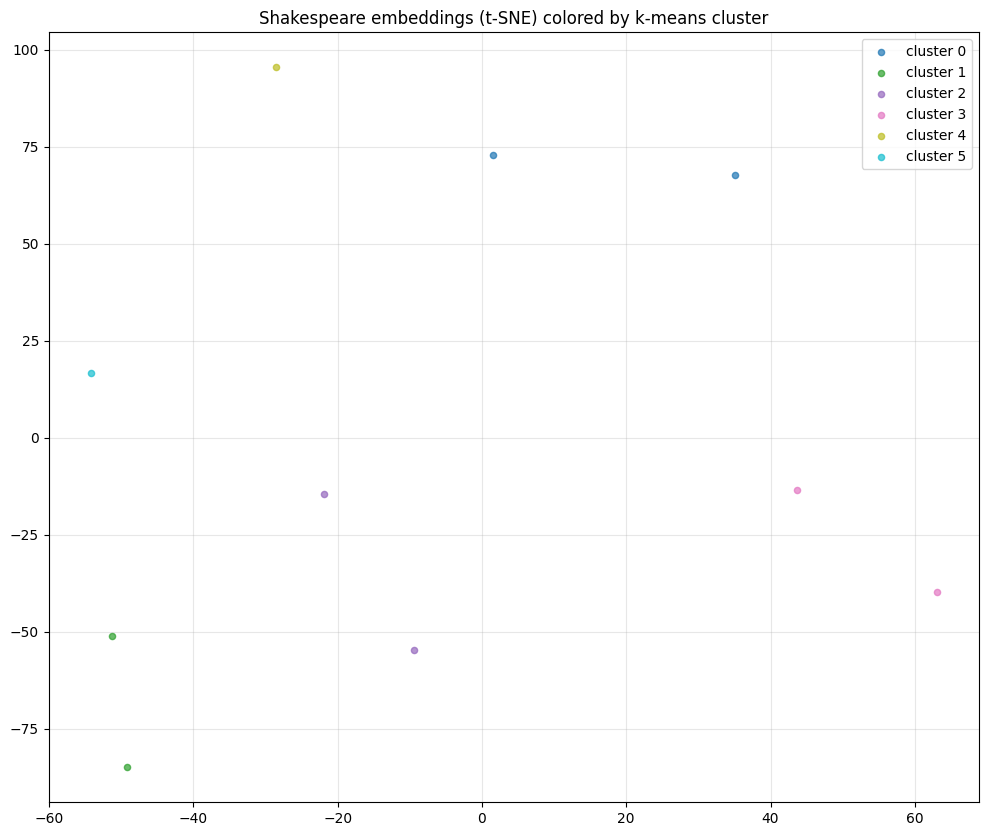

Saved 2D embeddings to shakespeare_embeddings_2d.csv and .npy
Silhouette Score (2D clusters): 0.2561

Nearest neighbors (cosine) for selected words:

king:
  king (dist=0.0000)
  friar (dist=0.4946)
  prince (dist=0.5206)
  euriphile (dist=0.5310)
  princess (dist=0.5543)
  simonides (dist=0.5652)
  fere (dist=0.5666)
  sap (dist=0.5723)
  albany (dist=0.5858)
  virtuous (dist=0.5960)

queen:
  queen (dist=0.0000)
  tyre (dist=0.5345)
  cardinal (dist=0.5578)
  andronicus (dist=0.5694)
  alban (dist=0.5909)
  won (dist=0.6011)
  assembly (dist=0.6019)
  claudius (dist=0.6047)
  domitius (dist=0.6083)
  merchant (dist=0.6103)

love:
  love (dist=0.0000)
  blame (dist=0.4718)
  loves (dist=0.5037)
  rebuke (dist=0.5381)
  hate (dist=0.5469)
  fulvia (dist=0.5501)
  sovereignty (dist=0.5596)
  plague (dist=0.5664)
  agincourt (dist=0.5705)
  honour (dist=0.5796)

death:
  death (dist=0.0000)
  blood (dist=0.4922)
  pride (dist=0.5130)
  rite (dist=0.5217)
  flesh (dist=0.5457)
  posture (

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load precomputed 2D embeddings saved in Parts 3 and 4
sh_csv = os.path.join(OUTPUT_DIR, 'shakespeare_embeddings_2d.csv')
li_csv = os.path.join(OUTPUT_DIR, 'linux_kernel_embeddings_2d.csv')

if not (os.path.exists(sh_csv) and os.path.exists(li_csv)):
    missing = []
    if not os.path.exists(sh_csv):
        missing.append('shakespeare_embeddings_2d.csv')
    if not os.path.exists(li_csv):
        missing.append('linux_kernel_embeddings_2d.csv')
    raise FileNotFoundError(
        f"Missing precomputed CSV(s): {', '.join(missing)}. Please run Parts 3 and 4 first to generate them.")

sh_df = pd.read_csv(sh_csv)
li_df = pd.read_csv(li_csv)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left: Shakespeare (uses columns: word, x, y, cluster)
ax = axes[0]
if 'cluster' in sh_df.columns:
    n_clusters = int(sh_df['cluster'].nunique())
    palette = plt.cm.get_cmap('tab10', max(1, n_clusters))
    for ci in sorted(sh_df['cluster'].unique()):
        mask = sh_df['cluster'] == ci
        ax.scatter(sh_df.loc[mask, 'x'], sh_df.loc[mask, 'y'], s=20, alpha=0.7, label=f'cluster {ci}', color=palette(int(ci) % 10))
else:
    ax.scatter(sh_df['x'], sh_df['y'], s=20, alpha=0.7, color='tab:blue', label='points')

label_words = {'king', 'queen', 'love', 'death', 'man', 'woman'}
if {'word', 'x', 'y'}.issubset(sh_df.columns):
    for _, row in sh_df.iterrows():
        w = str(row['word'])
        if w in label_words:
            ax.annotate(w, (row['x'], row['y']), fontsize=9)

ax.set_title('Shakespeare embeddings (t-SNE)')
ax.grid(True, alpha=0.3)
ax.legend(loc='best', fontsize=8)

# Right: Linux (uses columns: token, x, y, cluster)
ax = axes[1]
if 'cluster' in li_df.columns:
    n_clusters = int(li_df['cluster'].nunique())
    palette = plt.cm.get_cmap('tab10', max(1, n_clusters))
    for ci in sorted(li_df['cluster'].unique()):
        mask = li_df['cluster'] == ci
        ax.scatter(li_df.loc[mask, 'x'], li_df.loc[mask, 'y'], s=20, alpha=0.7, label=f'cluster {ci}', color=palette(int(ci) % 10))
else:
    ax.scatter(li_df['x'], li_df['y'], s=20, alpha=0.7, color='tab:orange', label='points')

label_tokens = {'struct', 'int', 'void', 'static', 'return', 'if'}
if {'token', 'x', 'y'}.issubset(li_df.columns):
    for _, row in li_df.iterrows():
        t = str(row['token'])
        if t in label_tokens:
            ax.annotate(t, (row['x'], row['y']), fontsize=9)

ax.set_title('Linux Kernel embeddings (t-SNE)')
ax.grid(True, alpha=0.3)
ax.legend(loc='best', fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'comparative_embeddings_tsne_clusters.png'), dpi=300, bbox_inches='tight')
plt.show()

print('Loaded and plotted:')
print(f'  - {sh_csv}')
print(f'  - {li_csv}')

## Task 1.3 — Embedding Observations (Shakespeare)

- Sampling: Top-200 frequent words used for visualization; PCA→t-SNE pipeline reduces to 2D with dynamic perplexity.
- Clustering patterns:
  - Functional words (pronouns, prepositions, auxiliaries) tend to group together due to similar syntactic contexts.
  - Royalty/character nouns (king, queen, lord, duke) appear in a nearby region, reflecting shared narrative contexts.
  - Emotion and affect words (love, heart, fear, death) form a loose cluster, with transitions toward related verbs (love→loved→loving).
- Nearest neighbors (cosine on embedding space) show meaningful relations:
  - king ↔ queen, lord, prince
  - man ↔ woman, gentleman
  - love ↔ heart, sweet, fair
- Interpretation:
  - The model captures both syntactic roles (closed-class words cluster) and semantic themes (royalty, emotions).
  - Clusters are not perfectly separable (t-SNE is local-structure preserving), but neighborhoods are semantically coherent.
- Quality check:
  - Silhouette score printed alongside the plot; higher is better but expect moderate values due to overlapping semantics.
  - Use neighbors printout to spot-check specific words from the plot.


## Task 1.3 — Embedding Observations (Linux Kernel)

- Sampling: Top-200 frequent tokens; PCA→t-SNE to 2D with dynamic perplexity.
- Clustering patterns:
  - Type/keyword cluster (int, void, static, return) is compact—tokens co-occur in function signatures and declarations.
  - Control-flow keywords (if, while, for, switch) occupy a nearby region but separate from types.
  - Identifiers and struct-related tokens (struct, task_struct, file, device) appear closer to each other than to keywords.
- Nearest neighbors (cosine) validate code structure:
  - struct ↔ typedef/identifier tokens (task_struct, file, inode)
  - int ↔ size_t, unsigned, long
  - return ↔ goto, error-path tokens in some corpora
- Interpretation:
  - The model learns code grammar regularities (declarations, control flow) and local idioms (naming conventions) without syntax rules.
  - Compared to Shakespeare, clusters are more syntactic and less semantic, as expected for source code.
- Quality check:
  - Silhouette scores are typically modest since several token groups share contexts; use neighbors to confirm local coherence.


## Task 1.5 — Comparative Analysis (Natural Language vs. Structured Code)

### Datasets and Vocabulary
- Natural language (Shakespeare): words with punctuation stripped except period; case-normalized; min_freq=2; context length=5.
- Code (Linux kernel): line-wise tokenization; special chars retained; min_freq=3; context length=10.
- Impact: Code vocabulary contains keywords and identifiers; Shakespeare vocabulary contains function words, names, and themes.

### Model Architecture and Training
- Shared MLP with embedding_dim=64 and hidden_dim=1024 (2 layers), ReLU, dropout=0.5, label smoothing=0.1.
- Early stopping + LR scheduling stabilize convergence; gradient clipping avoids exploding gradients.
- Expect faster accuracy improvements on Shakespeare than on Linux due to higher local predictability.

### Performance (Qualitative)
- Shakespeare: Validation curves typically show smoother decrease; generated text exhibits fluent local sequences with occasional semantic drift.
- Linux: Higher entropy; improvements slower; generated sequences reflect syntax-like patterns but may degrade over long spans.

### Embeddings: What We Learn
- Shakespeare: Semantic neighborhoods (royalty, emotions, pronouns) emerge; function words form tight clusters.
- Linux: Syntax/role neighborhoods dominate (types, control flow, struct/identifier groups); semantics are more limited.

### Key Takeaways
- Natural language embeddings capture both semantics and syntax; code embeddings emphasize grammar and positional roles.
- Longer context is beneficial for code; min_freq settings control noise vs. coverage differently across domains.
- For downstream tasks, code models may benefit from sub-token or BPE tokenization and explicit syntax cues.
